# Data Preprocessing

In [82]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the Free Energy of Solvation dataset
dataset = MoleculeNet(root=".", name="FreeSolv")

In [83]:
data = dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  485
Dataset length:  <bound method InMemoryDataset.len of FreeSolv(642)>
Dataset sample:  Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])
Sample  nodes:  13
Sample  edges:  26


In [84]:
# Investiagte the features of the node of graph 
data[0].x

# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

# See the target value of data[0]
data[0].y

tensor([[-11.0100]])

In [85]:
data[0]["smiles"]


'CN(C)C(=O)c1ccc(cc1)OC'

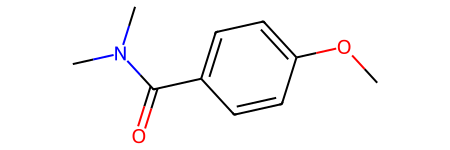

In [86]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

# Model definition

In [87]:
import torch
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

class GCN(torch.nn.Module):
    def __init__(self, feature_count, hidden_dim, out_channels, num_deepLayers):
        # Init parent
        super(GCN, self).__init__()
        # GCN layers
        self.layersCount = num_deepLayers

        self.Convlayers = nn.ModuleList()

        for ii in range(self.layersCount):
            in_channels = feature_count if ii ==0 else hidden_dim
            self.Convlayers.append(SAGEConv(in_channels, hidden_dim))

        # Output layer
        self.linear = Linear(hidden_dim*2+1, out_channels)

    def forward(self, data):

        x, edge_index, batch_index = data.x, data.edge_index, data.batch
        x = x.float()
        #print(data[0].num_nodes)
       # print(batch_index)
        Num_atoms = []
        for ii in range(len(data)):
            Num_atoms.append(data[ii].num_nodes)


        Num_atoms = torch.tensor(Num_atoms, dtype = torch.float).view(-1,1)


        for jj in range(self.layersCount):
            x = self.Convlayers[jj](x, edge_index)
            # if jj != self.layersCount:
            #     x = F.relu(x)
            x = F.tanh(x)

        #print(num_atoms)
        embedding = torch.cat([gmp(x, batch_index), 
                            gap(x, batch_index), Num_atoms], dim=1)
        # returned hidden is [num_graphs, hidden_dim]
        #print(hidden.shape)

        # Apply a final (linear) classifier.

        x = self.linear(embedding)
        #print(x.shape)

        return x

model = GCN(data.num_features, 5,1,2)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (Convlayers): ModuleList(
    (0): SAGEConv(9, 5, aggr=mean)
    (1): SAGEConv(5, 5, aggr=mean)
  )
  (linear): Linear(in_features=11, out_features=1, bias=True)
)
Number of parameters:  162


# Training

In [94]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  
batch_size = 32
pretrained = True
model_path = "GraphModelSG_pretrained.pth"
if pretrained:
   model.load_state_dict(torch.load(model_path))



# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)

train_loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=batch_size, shuffle=True, drop_last = True)

In [95]:
def train():
    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      model.train()
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch) 
      # Calculating the loss and gradients
      #print(pred.shape)
      #print(batch.y.shape)
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

print("Starting training...")
losses = []
for epoch in range(1000):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.9200658798217773
Epoch 100 | Train Loss 2.6314754486083984
Epoch 200 | Train Loss 1.938270092010498
Epoch 300 | Train Loss 3.157993793487549
Epoch 400 | Train Loss 1.4312281608581543
Epoch 500 | Train Loss 3.0882961750030518
Epoch 600 | Train Loss 2.452904224395752
Epoch 700 | Train Loss 1.9299613237380981
Epoch 800 | Train Loss 1.0989326238632202
Epoch 900 | Train Loss 1.152491569519043


In [96]:
model_path = "GraphModelSG_pretrained.pth"
torch.save(model.state_dict(), model_path)

In [97]:
# Visualize learning (training loss)
import plotly.graph_objects as go
from plotly.offline import iplot


losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 

trace = go.Scatter(x = loss_indices, y = losses_float, mode = "lines")

layout = go.Layout(title = "losses during training", xaxis=dict(title = "epoch"),
                   yaxis = dict(title = "loss"))

figure = go.Figure(data = [trace], layout=layout)

iplot(figure)

In [98]:
import pandas as pd 

# Analyze the results for one batch
y_real = []
y_pred = []
with torch.no_grad():
    model.eval()
    for batch in train_loader:
        pred = model(batch)
        y_real.append(batch.y.tolist())
        y_pred.append(pred.tolist())

    y_pred = torch.reshape(torch.tensor(y_pred), (-1,1))
    y_real = torch.reshape(torch.tensor(y_real), (-1,1))

    y_pred = torch.squeeze(y_pred)
    y_real = torch.squeeze(y_real)


In [99]:
trace = go.Scatter(x = y_real,y = y_pred, mode = "markers")
line_trace = go.Scatter(x = [min(y_real), max(y_real)],
                        y = [min(y_real), max(y_real)],
                        mode = "lines",
                        marker=dict(color='blue'),
                        name='Perfect Prediction')
layout = go.Layout(title = "predicted values vs real values", xaxis=dict(title = "real"),
                   yaxis = dict(title = "pred"))

figure = go.Figure(data = [trace, line_trace], layout=layout)

iplot(figure)

In [81]:
trace = go.Scatter(x = y_real,y = y_pred, mode = "markers")
line_trace = go.Scatter(x = [min(y_real), max(y_real)],
                        y = [min(y_real), max(y_real)],
                        mode = "lines",
                        marker=dict(color='blue'),
                        name='Perfect Prediction')
layout = go.Layout(title = "predicted values vs real values", xaxis=dict(title = "real"),
                   yaxis = dict(title = "pred"))

figure = go.Figure(data = [trace, line_trace], layout=layout)

iplot(figure)